# Regression Evaluation Metrics

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import gdown
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Learning outcomes 

From this lecture, students are expected to be able to:

- Carry out feature transformations on somewhat complicated dataset. 
- Visualize transformed features as a dataframe. 
- Use `Ridge` and `RidgeCV`.
- Explain how `alpha` hyperparameter of `Ridge` relates to the fundamental tradeoff. 
- Examine coefficients of transformed features.  
- Appropriately select a scoring metric given a regression problem.
- Interpret and communicate the meanings of different scoring metrics on regression problems.
    - MSE, RMSE, $R^2$, MAPE
- Apply log-transform on the target values in a regression problem with `TransformedTargetRegressor`.

## Dataset

In this lecture, we'll be using [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/). As usual, to run this notebook you'll need to download the data. For this dataset, train and test have already been separated. We'll be working with the train portion in this lecture. 

In [2]:
if not os.path.exists("data/housing-kaggle-train.csv"):
    md5 = "80ccab65fb115cbad143dbbd2bcd5577"
    url = "https://drive.google.com/file/d/1DenJFG6xB_FwZT1n6w-thZh6LcV5LJss/view?usp=sharing"
    output = "data/housing-kaggle-train.csv"
    gdown.cached_download(url, output, md5=md5, fuzzy=True)

In [3]:
df = pd.read_csv("data/housing-kaggle-train.csv")
train_df, test_df = train_test_split(df, test_size=0.10, random_state=123)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
302,303,20,RL,118.0,13704,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2006,WD,Normal,205000
767,768,50,RL,75.0,12508,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,1300,7,2008,WD,Normal,160000
429,430,20,RL,130.0,11457,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,175000
1139,1140,30,RL,98.0,8731,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,144000
558,559,60,RL,57.0,21872,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,8,2008,WD,Normal,175000


- The supervised machine learning problem is predicting housing price given features associated with properties. 
- Here, the target is `SalePrice`, which is continuous. So it's a **regression problem** (as opposed to classification).

### Let's separate `X` and `y`

In [4]:
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"]

X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"]

### EDA

In [5]:
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1314.000000,1314.000000,1089.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1307.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000
mean,734.182648,56.472603,69.641873,10273.261035,6.076104,5.570015,1970.995434,1984.659056,102.514155,441.425419,...,94.281583,45.765601,21.726788,3.624049,13.987062,3.065449,46.951294,6.302131,2007.840183,179802.147641
std,422.224662,42.036646,23.031794,8997.895541,1.392612,1.112848,30.198127,20.639754,178.301563,459.276687,...,125.436492,65.757545,60.766423,30.320430,53.854129,42.341109,522.283421,2.698206,1.332824,79041.260572
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,369.250000,20.000000,59.000000,7500.000000,5.000000,5.000000,1953.000000,1966.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129600.000000
50%,735.500000,50.000000,69.000000,9391.000000,6.000000,5.000000,1972.000000,1993.000000,0.000000,376.000000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162000.000000
75%,1099.750000,70.000000,80.000000,11509.000000,7.000000,6.000000,2000.000000,2004.000000,165.500000,704.750000,...,168.000000,66.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,212975.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1314 entries, 302 to 1389
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1314 non-null   int64  
 1   MSSubClass     1314 non-null   int64  
 2   MSZoning       1314 non-null   object 
 3   LotFrontage    1089 non-null   float64
 4   LotArea        1314 non-null   int64  
 5   Street         1314 non-null   object 
 6   Alley          81 non-null     object 
 7   LotShape       1314 non-null   object 
 8   LandContour    1314 non-null   object 
 9   Utilities      1314 non-null   object 
 10  LotConfig      1314 non-null   object 
 11  LandSlope      1314 non-null   object 
 12  Neighborhood   1314 non-null   object 
 13  Condition1     1314 non-null   object 
 14  Condition2     1314 non-null   object 
 15  BldgType       1314 non-null   object 
 16  HouseStyle     1314 non-null   object 
 17  OverallQual    1314 non-null   int64  
 18  Overal

### `pandas_profiler`

`pandas-profiling` generates profile reports from a pandas `DataFrame`. 
The pandas `df.describe()` function is handy yet a little basic for exploratory data analysis. 
`pandas-profiling` extends pandas `DataFrame` with `df.profile_report()`, which automatically generates a standardized univariate and multivariate report for data understanding.

We do not have `pandas_profiling` in our course environment. You will have to install it in the environment on your own if you want to run the code below. 

```conda install -c conda-forge pandas-profiling```

In [7]:
from pandas_profiling import ProfileReport

### profiling is slow and huge
### Uncomment if you are interest
# profile = ProfileReport(train_df, title="Pandas Profiling Report")  # , minimal=True)
# profile.to_notebook_iframe()

### Feature types 

- Do not blindly trust all the info given to you by automated tools. 
- How does pandas profiling figure out the data type?
    - You can look at the Python data type and say floats are numeric, strings are categorical.
    - However, in doing so you would miss out on various subtleties such as some of the string features being ordinal rather than truly categorical.
    - Also, it will think free text is categorical.

- In addition to tools such as above, it's important to go through data description to understand the data.
- The data description for our dataset is available [here](https://www.kaggle.com/c/home-data-for-ml-course/data?select=data_description.txt).     

### Identify feature types 

- We have mixed feature types and a bunch of missing values. 
- Now, let's identify feature types and transformations. 

- Let's get the numeric-looking columns. 

In [8]:
numeric_looking_columns = X_train.select_dtypes(include=np.number).columns.tolist()
print(numeric_looking_columns)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


Not all numeric looking columns are necessarily numeric. 

In [9]:
train_df["MSSubClass"].unique()

array([ 20,  50,  30,  60, 160,  85,  90, 120, 180,  80,  70,  75, 190,
        45,  40], dtype=int64)

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES


Also, month sold is more of a categorical feature than a numeric feature. 

In [10]:
train_df["MoSold"].unique() # Month Sold

array([ 1,  7,  3,  5,  8, 10,  6,  9, 12,  2,  4, 11], dtype=int64)

In [11]:
drop_features = ["Id"]
numeric_features = [
    "BedroomAbvGr", "KitchenAbvGr", "LotFrontage", "LotArea", "OverallQual", "OverallCond", "YearBuilt",
    "YearRemodAdd", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF",
    "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath",
    "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF",
    "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "YrSold"
]

In [12]:
set(numeric_looking_columns) - set(numeric_features) - set(drop_features)

{'MSSubClass', 'MoSold'}

We'll treat the above numeric-looking features as categorical features. 

- There are a bunch of ordinal features in this dataset. 
- Ordinal features with the same scale 
    - Poor (Po), Fair (Fa), Typical (TA), Good (Gd), Excellent (Ex)
    - These we'll be calling `ordinal_features_reg`.
- Ordinal features with different scales
    - These we'll be calling `ordinal_features_oth`.

In [13]:
ordinal_features_reg = [
    "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC",
    "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"
]
ordering = ["Po", "Fa", "TA", "Gd", "Ex"]  # if N/A it will just impute something, per below
ordering_ordinal_reg = [ordering] * len(ordinal_features_reg)
ordering_ordinal_reg

[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
 ['Po', 'Fa', 'TA', 'Gd', 'Ex']]

We'll pass the above as categories in our `OrdinalEncoder`. 

- There are a bunch more ordinal features using different scales.
  - These we'll be calling `ordinal_features_oth`. 
  - We are encoding them separately. 

In [14]:
ordinal_features_oth = [
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinType2",
    "Functional",
    "Fence",
]
ordering_ordinal_oth = [
    ['NA', 'No', 'Mn', 'Av', 'Gd'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],    
    ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
]

The remaining features are categorical features.

In [15]:
categorical_features = list(
    set(X_train.columns)
    - set(numeric_features)
    - set(ordinal_features_reg)
    - set(ordinal_features_oth)    
    - set(drop_features)
)
categorical_features

['Utilities',
 'Foundation',
 'LandSlope',
 'LotShape',
 'MasVnrType',
 'Condition2',
 'HouseStyle',
 'LotConfig',
 'Alley',
 'LandContour',
 'Street',
 'SaleType',
 'MSZoning',
 'Exterior1st',
 'RoofMatl',
 'Electrical',
 'MSSubClass',
 'PavedDrive',
 'Heating',
 'MiscFeature',
 'Condition1',
 'MoSold',
 'Exterior2nd',
 'SaleCondition',
 'BldgType',
 'Neighborhood',
 'GarageType',
 'RoofStyle',
 'CentralAir',
 'GarageFinish']

- We are not doing it here but we can engineer our own features too. 
- Would price per square foot be a good feature to add in here?

### Applying feature transformations

- Since we have mixed feature types, let's use `ColumnTransformer` to apply different transformations on different features types.  

In [16]:
from sklearn.compose import ColumnTransformer, make_column_transformer

numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
ordinal_transformer_reg = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_reg)
)
ordinal_transformer_oth = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(categories=ordering_ordinal_oth)
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)
preprocessor = make_column_transformer(
    ("drop", drop_features),
    (numeric_transformer, numeric_features),
    (ordinal_transformer_reg, ordinal_features_reg),
    (ordinal_transformer_oth, ordinal_features_oth),    
    (categorical_transformer, categorical_features)
)

### Examining the preprocessed data

In [17]:
preprocessor.fit(X_train) # Calling fit to examine all the transformers.
preprocessor.named_transformers_

{'drop': 'drop',
 'pipeline-1': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 'pipeline-2': Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                             ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                      

In [18]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)
new_columns = numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns

In [19]:
X_train_enc = pd.DataFrame(preprocessor.transform(X_train), index=X_train.index, columns=new_columns)
X_train_enc.head()

,BedroomAbvGr,KitchenAbvGr,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,CentralAir_N,CentralAir_Y,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_missing
302,0.154795,-0.222647,2.312501,0.381428,0.663680,-0.512408,0.993969,0.840492,0.269972,-0.961498,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
767,1.372763,-0.222647,0.260890,0.248457,-0.054669,1.285467,-1.026793,0.016525,-0.573129,0.476092,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
429,0.154795,-0.222647,2.885044,0.131607,-0.054669,-0.512408,0.563314,0.161931,-0.573129,1.227559,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1139,0.154795,-0.222647,1.358264,-0.171468,-0.773017,-0.512408,-1.689338,-1.679877,-0.573129,0.443419,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
558,0.154795,-0.222647,-0.597924,1.289541,0.663680,-0.512408,0.828332,0.598149,-0.573129,0.354114,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [20]:
X_train.shape

(1314, 80)

In [21]:
X_train_enc.shape

(1314, 263)

We went from 80 features to 263 features!! 

### Other possible preprocessing?  

- There is a lot of room for improvement ...
- We're just using `SimpleImputer`.
    - In reality we'd want to go through this more carefully.
    - We may also want to drop some columns that are almost entirely missing.    
- We could also check for outliers, and do other exploratory data analysis (EDA).
- But for now this is good enough ...    

<br><br><br><br>

## Model building 

### `DummyRegressor`

In [22]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.000999,0.000000,-0.003547,0.0
1,0.000986,0.000000,-0.001266,0.0
2,0.001035,0.000000,-0.011767,0.0
3,0.000000,0.001000,-0.006744,0.0
4,0.000996,0.000926,-0.076533,0.0
5,0.001067,0.000000,-0.003133,0.0
6,0.000966,0.000000,-0.000397,0.0
7,0.000994,0.000000,-0.003785,0.0
8,0.001913,0.000000,-0.001740,0.0
9,0.001189,0.000992,-0.000117,0.0


### Apply `Ridge`

- Recall that we are going to use `Ridge()` instead of `LinearRegression()` in this course. 
    - It has a hyperparameter `alpha` which controls the fundamental tradeoff. 

In [23]:
lr_pipe = make_pipeline(preprocessor, Ridge())
pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.097124,0.009651,0.861355,0.911906
1,0.041196,0.009023,0.812301,0.913861
2,0.037846,0.007289,0.775283,0.915963
3,0.043017,0.007334,0.874519,0.910849
4,0.029716,0.014887,0.851969,0.911622
5,0.030043,0.015161,0.826198,0.910176
6,0.038019,0.006696,0.825533,0.913781
7,0.037585,0.016145,0.872238,0.910071
8,0.030447,0.014463,0.196663,0.921448
9,0.032297,0.015633,0.890474,0.908221


- Quite a bit of variation in the test scores. 
- Performing poorly in fold 8. Not sure why. 

### Tuning `alpha` hyperparameter of `Ridge`
- Recall that `Ridge` has a hyperparameter `alpha` that controls the fundamental tradeoff.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the inverse of `C`.
- That is, large `C` is like small `alpha` and vice versa.
- Smaller `alpha`: lower training error (overfitting)

In [24]:
alphas = 10.0 ** np.arange(-5, 5, 1)
train_scores = []
cv_scores = []
for alpha in alphas:
    lr = make_pipeline(preprocessor, Ridge(alpha=alpha))
    results = cross_validate(lr, X_train, y_train, return_train_score=True)
    train_scores.append(np.mean(results["train_score"]))
    cv_scores.append(np.mean(results["test_score"]))

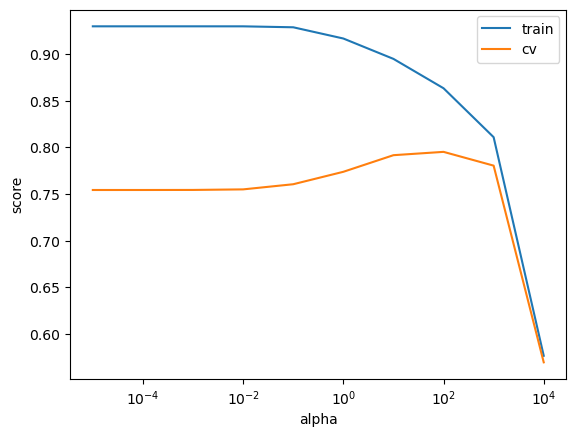

In [25]:
plt.semilogx(alphas, train_scores, label="train")
plt.semilogx(alphas, cv_scores, label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

In [26]:
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

100.0

- It seems alpha=100 is the best choice here.

- General intuition: larger `alpha` leads to smaller coefficients.
- Smaller coefficients mean the predictions are less sensitive to changes in the data.
- Hence less chance of overfitting (seeing big dependencies when you shouldn't).

### `RidgeCV`

BTW, because it's so common to want to tune `alpha` with `Ridge`, sklearn provides a class called `RidgeCV`, which automatically tunes `alpha` based on cross-validation.

In [27]:
ridgecv_pipe = make_pipeline(preprocessor, RidgeCV(alphas=alphas, cv=10))
ridgecv_pipe.fit(X_train, y_train);

In [28]:
best_alpha = ridgecv_pipe.named_steps['ridgecv'].alpha_

### Let's examine the coefficients 

In [29]:
lr_tuned = make_pipeline(preprocessor, Ridge(alpha=best_alpha))
lr_tuned.fit(X_train, y_train)
lr_preds = lr_tuned.predict(X_test)
lr_preds[:10]

array([228728.1963872 , 104718.39905565, 155778.96723311, 246316.71119031,
       127633.10676873, 243207.19441128, 304930.24461291, 145374.59435295,
       157059.38983893, 128487.51979632])

In [30]:
lr_preds.max(), lr_preds.min()

(390726.1064742327, 30791.0925054208)

Let's get the feature names of the transformed data. 

In [31]:
ohe_columns = list(
    preprocessor.named_transformers_["pipeline-4"]
    .named_steps["onehotencoder"]
    .get_feature_names(categorical_features)
)
new_columns = numeric_features + ordinal_features_reg + ordinal_features_oth + ohe_columns


In [32]:
df = pd.DataFrame(
    data={
        "features": new_columns,
        "coefficients": lr_tuned.named_steps["ridge"].coef_,
    }
)

In [33]:
df.sort_values("coefficients",ascending=False)

,features,coefficients
4,OverallQual,14484.902165
16,GrLivArea,11704.053037
235,Neighborhood_NridgHt,9662.969631
234,Neighborhood_NoRidge,9497.598615
36,BsmtQual,8073.088562
...,...,...
128,RoofMatl_ClyTile,-3992.399179
93,LandContour_Bnk,-5001.996997
227,Neighborhood_Gilbert,-5197.585536
224,Neighborhood_CollgCr,-5467.463086


So according to this model:

- As `OverallQual` feature gets bigger the housing price will get bigger.
- Presence of `Neighborhood_Edwards` will result in smaller median house value. 

In [34]:
X_train_enc['Neighborhood_Edwards']

302     0.0
767     0.0
429     0.0
1139    0.0
558     0.0
       ... 
1041    0.0
1122    1.0
1346    0.0
1406    0.0
1389    0.0
Name: Neighborhood_Edwards, Length: 1314, dtype: float64

<br><br><br><br>

## Regression score functions


- We aren't doing classification anymore, so we can't just check for equality:

In [35]:
lr_tuned.predict(X_train) == y_train

302     False
767     False
429     False
1139    False
558     False
        ...  
1041    False
1122    False
1346    False
1406    False
1389    False
Name: SalePrice, Length: 1314, dtype: bool

In [36]:
y_train.values

array([205000, 160000, 175000, ..., 262500, 133000, 131000], dtype=int64)

In [37]:
lr_tuned.predict(X_train)

array([212894.62756285, 178502.78223444, 189937.18327372, ...,
       245233.6751565 , 129863.13373552, 135439.89186716])

Instead, we aim to evaluate how close the prediction is to the truth.

<!-- ![regression_scores.png](img/regression_scores.png) -->
<center><img src="img/regression_scores.png" alt="regression_scores.png" width="75%"></center>

### Metrics for regression

We need a score that reflects how right/wrong each prediction is.

A number of popular scoring functions for regression. We are going to look at some common metrics: 

- mean squared error (MSE)
- root mean squared error (RMSE)
- Mean absolute percentage error (MAPE)
- Coefficient of determination ($R^2$)

See [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) for more details. 

### Mean squared error (MSE)

- A common metric is mean squared error:

<!-- ![mse.png](img/mse.png) -->
<center><img src="img/mse.png" alt="mse.png" width="75%"></center>

In [38]:
preds = lr_tuned.predict(X_train)

In [39]:
np.mean((y_train - preds) ** 2)

873230473.3636103

Perfect predictions would have MSE=0.

In [40]:
np.mean((y_train - y_train) ** 2)

0.0

This is also implemented in sklearn:

In [41]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, preds)

873230473.3636101

- MSE looks huge and unreasonable. There is an error of ~\$1 Billion!
- Is this score good or bad?

- Unlike classification, with regression **our target has units**. 
- The target is in dollars, the mean squared error is in $dollars^2$ 
- The score also depends on the scale of the targets. 
- If we were working in cents instead of dollars, our MSE would be $10,000 \times (100^2$) higher!

In [42]:
np.mean((y_train * 100 - preds * 100) ** 2)

8732304733636.105

### Root mean squared error or RMSE

- The MSE above is in ${dollars}^2$.
- A more relatable metric would be the root mean squared error, or RMSE

<!-- ![rmse.png](img/rmse.png) -->
<center><img src="img/rmse.png" alt="rmse.png" width="75%"></center>

In [43]:
np.sqrt(mean_squared_error(y_train, lr_tuned.predict(X_train)))

29550.47331877461

- Error of \$30,000 makes more sense.
- Can we dig deeper?

### Mean absolute percentage error (MAPE)

- We got an RMSE of ~$30,000 before. 

Question: Is an error of \$30,000 acceptable?

- For a house worth \$600k, it seems reasonable! That's 5% error.
- For a house worth \$60k, that is terrible. It's 50% error.

We have both of these cases in our dataset.

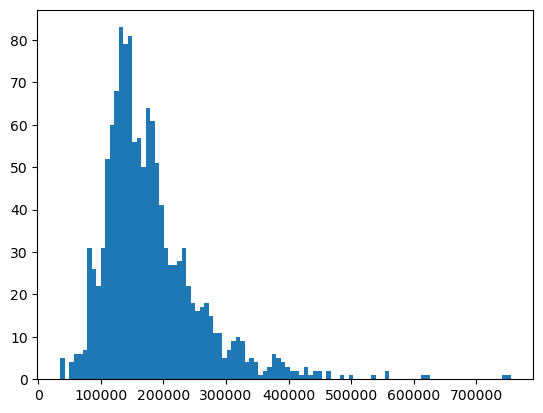

In [50]:
plt.hist(y_train, bins=100);

How about looking at percent error? 

In [51]:
pred_train = lr_tuned.predict(X_train)
percent_errors = (pred_train - y_train) / y_train * 100.0
percent_errors

302      3.851038
767     11.564239
429      8.535533
1139   -16.371069
558     17.177968
          ...    
1041    -0.496571
1122   -28.696351
1346    -6.577648
1406    -2.358546
1389     3.389230
Name: SalePrice, Length: 1314, dtype: float64

These are both positive (predict too high) and negative (predict too low).

We can look at the **mean** **absolute** **percent** error (MAPE):

In [52]:
np.abs(percent_errors)

302      3.851038
767     11.564239
429      8.535533
1139    16.371069
558     17.177968
          ...    
1041     0.496571
1122    28.696351
1346     6.577648
1406     2.358546
1389     3.389230
Name: SalePrice, Length: 1314, dtype: float64

And, like MSE, we can take the average over examples.

<!-- ![mape.png](img/mape.png) -->
<center><img src="img/mape.png" alt="mape.png" width="40%"></center>

In [53]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))

In [54]:
mape(y_train, pred_train)

10.093121294225256

- Ok, this is quite interpretable.
- On average, we have around 10% error.

### Coefficient of determination ($R^2$)

A common score is the $R^2$

- This is the score that `sklearn` uses by default when you call score():
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: similar to mean squared error, but flipped (higher is better), and normalized so the max is 1.


#### $R^2$ is a normalized MSE by a dummy regressor

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y_i})^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

<!-- ![r2.png](img/r2.png) -->
<center><img src="img/r2.png" alt="r2.png" width="60%"></center>

Key points:
- The maximum is 1 for perfect predictions
- Negative values are very bad: "worse than DummyRegressor" (very bad)


(optional) Warning: MSE is "reversible" but $R^2$ is not:

In [ ]:
mean_squared_error(y_train, preds)

873230473.3636101

In [ ]:
mean_squared_error(preds, y_train)

873230473.3636101

### Transforming the targets

- Does `.fit()` know we care about MAPE?
- No, it doesn't. Why are we minimizing MSE (or something similar) if we care about MAPE??
- When minimizing MSE, the expensive houses will dominate because they have the biggest error.
- Which is better for RMSE?

Model A

- Example 1: Truth: \$50k, Prediction: \\$100k
- Example 2: Truth: \$500k, Prediction: \\$550k
- RMSE: $50k
- MAPE: 45%


Model B

- Example 1: Truth: \$50k, Prediction: \\$60k
- Example 2: Truth: \$500k, Prediction: \\$600k
- RMSE: $71k
- MAPE: 20%

**Large values dominate RMSE.**

- How can we get `.fit()` to think about MAPE?
- A common practice which tends to work is log transforming the targets.
- That is, transform $y\rightarrow \log(y)$ because logrithmic scale penalizes the large values.

<!-- ![log_plot.png](img/log_plot.png) -->
<center><img src="img/log_plot.png" alt="log_plot.png" width="50%"></center> 

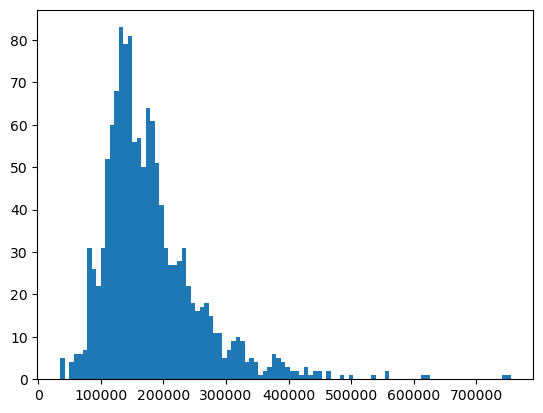

In [55]:
plt.hist(y_train, bins=100);

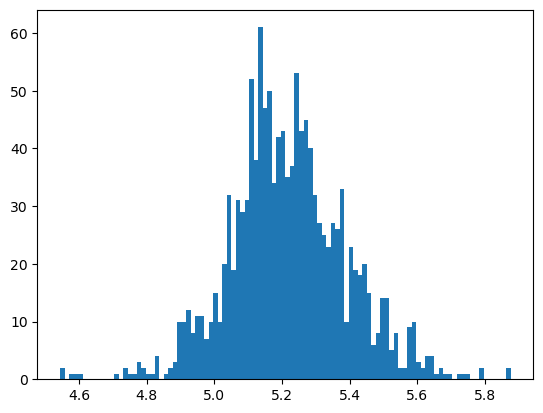

In [56]:
plt.hist(np.log10(y_train), bins=100);

We can incorporate this in our pipeline using `sklearn`. 

In [57]:
from sklearn.compose import TransformedTargetRegressor

In [58]:
ttr = TransformedTargetRegressor(Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1) 
# transformer for log transforming the target
ttr_pipe = make_pipeline(preprocessor, ttr)

In [59]:
ttr_pipe.fit(X_train, y_train); # y_train automatically transformed

In [60]:
ttr_pipe.predict(X_train)  # predictions automatically un-transformed

array([221355.29528077, 170663.43286226, 182608.09768702, ...,
       248575.94877669, 132148.9047652 , 133262.17638244])

In [61]:
mape(y_test, ttr_pipe.predict(X_test))

7.8086009242408645

We reduced MAPE from ~10% to ~8% with this trick! 

### Define customized scoring functions for `cross_validate`

- Let's try using MSE instead of the **default** $R^2$ score. 

In [62]:
pd.DataFrame(cross_validate(lr_tuned, X_train,  y_train, return_train_score=True, scoring="neg_mean_squared_error"))

,fit_time,score_time,test_score,train_score
0,0.039717,0.013001,-7.060346e+08,-9.383069e+08
1,0.033035,0.000000,-1.239851e+09,-8.267971e+08
2,0.034607,0.015610,-1.125125e+09,-8.763019e+08
3,0.033284,0.000000,-9.819320e+08,-8.847908e+08
4,0.033357,0.005552,-2.268434e+09,-7.397199e+08


You can choose score functions from a [list](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) provided by sklearn.

Actually you can make your **own** scorer from a performance metric or loss function.

You can check more about [`make_scorer`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).

In [63]:
def mape(true, pred):
    return 100.0 * np.mean(np.abs((pred - true) / true))


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=True)

pd.DataFrame(cross_validate(lr_tuned, X_train, y_train, return_train_score=True, scoring=mape_scorer))

,fit_time,score_time,test_score,train_score
0,0.036391,0.012586,9.699277,10.407124
1,0.033413,0.018299,10.803043,9.966190
2,0.030440,0.012711,11.836195,10.180734
3,0.038584,0.010045,10.784686,10.247198
4,0.030582,0.010089,12.196718,9.828607


In [64]:
scoring = {
    "r2": "r2",
    "mape_scorer": mape_scorer,
    "neg_root_mean_square_error": "neg_root_mean_squared_error",
    "neg_mean_squared_error": "neg_mean_squared_error",
}

pd.DataFrame(cross_validate(lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring)).T

,0,1,2,3,4
fit_time,3.813934e-02,3.115702e-02,1.685023e-02,3.379631e-02,3.388786e-02
score_time,1.223421e-02,8.022308e-03,1.664925e-02,1.618409e-02,2.430439e-02
test_r2,8.668969e-01,8.200460e-01,8.262644e-01,8.511854e-01,6.109505e-01
train_r2,8.551369e-01,8.636241e-01,8.579735e-01,8.561893e-01,8.834054e-01
test_mape_scorer,9.699277e+00,1.080304e+01,1.183620e+01,1.078469e+01,1.219672e+01
train_mape_scorer,1.040712e+01,9.966190e+00,1.018073e+01,1.024720e+01,9.828607e+00
test_neg_root_mean_square_error,-2.657131e+04,-3.521152e+04,-3.354288e+04,-3.133579e+04,-4.762808e+04
train_neg_root_mean_square_error,-3.063179e+04,-2.875408e+04,-2.960240e+04,-2.974543e+04,-2.719779e+04
test_neg_mean_squared_error,-7.060346e+08,-1.239851e+09,-1.125125e+09,-9.819320e+08,-2.268434e+09
train_neg_mean_squared_error,-9.383069e+08,-8.267971e+08,-8.763019e+08,-8.847908e+08,-7.397199e+08


In [65]:
mape(y_test, lr_tuned.predict(X_test))

9.496387589495997

### Using regression metrics with `scikit-learn`

- In `sklearn` you will notice that it has negative version of the metrics above (e.g., `neg_mean_squared_error`, `neg_root_mean_squared_error`). 
- The reason for this is that scores return a value to maximize, the higher the better.
- If you define your own scorer function and if you do not want this interpretation, you can set the `greater_is_better` parameter to False 

## Questions for class discussion 

### True/False 

1. Price per square foot would be a good feature to add in our `X`. 
2. The `alpha` hyperparameter of `Ridge` has similar interpretation of `C` hyperparameter of `LogisticRegression`; higher `alpha` means more complex model. 
3. In regression, one should use MAPE instead of MSE when relative (percent) error matters more than absolute error.
4. A lower RMSE value indicates a better model.
5. We can use still use precision and recall for regression problems but now we have other metrics we can use as well.

## Summary

- House prices dataset target is price, which is numeric -> regression rather than classification
- There are corresponding versions of all the tools we used:
    - `DummyClassifier` -> `DummyRegressor`
    - `LogisticRegression` -> `Ridge`
- `Ridge` hyperparameter `alpha` is like `LogisticRegression` hyperparameter `C`, but opposite meaning
- We'll avoid `LinearRegression` in this course.

- Scoring metrics
- $R^2$ is the default .score(), it is unitless, 0 is bad, 1 is best
- MSE (mean squared error) is in units of target squared, hard to interpret; 0 is best
- RMSE (root mean squared error) is in the same units as the target; 0 is best
- MAPE (mean average percent error) is unitless; 0 is best, 100 is bad